# Rice leaf classification


## Introduction
This code aims to test the chosen pretrained model with original images and preprocessed images. <br>

# 1. Import libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Load data ##
We have gathered all images in folder "train".<br>
Shuffled the images in each folder randomly.<br>
Split the images with ratio 8:1:1 as new training, validation and testing sets.<br>
Recorded the images' names in train_data.csv, val_data.csv and test_data.csv.

In [3]:
class CustomImageDataset(Dataset):
  def __init__(self, csv_file, transform=None):
    self.data_frame = pd.read_csv(csv_file)
    self.transform = transform
    self.classes = sorted(self.data_frame['class'].unique())
    self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_path = self.data_frame.loc[idx, "path"]
    image = Image.open(img_path).convert("RGB")
        
    label = self.data_frame.loc[idx, "class"]
    label_idx = self.class_to_idx[label]
    if self.transform:
      image = self.transform(image)

    return image, label_idx

In [57]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(), # convert a PIL Image or numpy.ndarray to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [58]:
import pandas as pd
DIR_CSV = "drive/MyDrive/"
train_set = CustomImageDataset(csv_file=DIR_CSV+"train_data1.csv", transform=transform)
val_set = CustomImageDataset(csv_file=DIR_CSV+"val_data1.csv", transform=transform)
test_set = CustomImageDataset(csv_file=DIR_CSV+"test_data1.csv", transform=transform)

In [49]:
from PIL import Image
train_set[301]

(tensor([[[-0.3541, -0.3198, -0.2684,  ..., -2.1179, -2.1179, -2.1179],
          [-0.2342, -0.3369, -0.3198,  ..., -2.1179, -2.1179, -2.1179],
          [-0.2684, -0.3369, -0.3369,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -0.5424, -0.6281, -0.4054],
          [-2.1179, -2.1179, -2.1179,  ..., -0.5082, -0.4397, -0.2684],
          [-2.1179, -2.1179, -2.1179,  ..., -0.4739, -0.3369, -0.3369]],
 
         [[ 0.0476,  0.1352,  0.2402,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.1877,  0.1001,  0.1702,  ..., -2.0357, -2.0357, -2.0357],
          [ 0.1352,  0.1001,  0.1527,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -0.1099, -0.2150, -0.0749],
          [-2.0357, -2.0357, -2.0357,  ..., -0.0749, -0.0224,  0.0826],
          [-2.0357, -2.0357, -2.0357,  ..., -0.0399,  0.1001,  0.0301]],
 
         [[-0.5844, -0.7413, -0.8633,  ..., -1.8044, -1.8044, -1.8044],
          [-0.4450, -0.7413,

In [51]:
test_set[4]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -0.6623, -1.7069, -2.0837],
          [-2.1179, -2.1179, -2.1179,  ..., -0.5082, -1.4843, -2.0837],
          [-2.1179, -2.1179, -2.1179,  ..., -0.4226, -0.8678, -2.0665],
          ...,
          [-1.2788, -0.1486, -0.1486,  ..., -2.1179, -2.1179, -2.1179],
          [-1.6384, -0.2171, -0.2342,  ..., -2.1179, -2.1179, -2.1179],
          [-1.6555, -0.2342, -0.2513,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -0.1800, -1.5280, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -0.0399, -1.2829, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ...,  0.0476, -0.6001, -1.9482],
          ...,
          [-1.1253,  0.2402,  0.3102,  ..., -2.0357, -2.0357, -2.0357],
          [-1.4755,  0.1702,  0.2227,  ..., -2.0357, -2.0357, -2.0357],
          [-1.4930,  0.1527,  0.2052,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -0.3753, -1.4036, -1.8044],
          [-1.8044, -1.8044,

In [8]:
DIR_MODEL = "drive/MyDrive/" # path to save model

In [59]:
len(train_set) # all data from csv
train_data = train_set
val_data = val_set
test_data = test_set

In [53]:
len(train_data)

2684

In [60]:
train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=4)

In [75]:
#@title


mean_train = np.zeros(3)
std_train = np.zeros(3)
mean_val = np.zeros(3)
std_val = np.zeros(3)

for images, _ in train_dataloader:
  mean_train += images.mean(axis=(0, 2, 3)).numpy()
  std_train += images.std(axis=(0, 2, 3)).numpy()

mean_train /= len(train_dataloader)
std_train /= len(train_dataloader)

for images, _ in val_dataloader:
  mean_val += images.mean(axis=(0, 2, 3)).numpy()
  std_val += images.std(axis=(0, 2, 3)).numpy()

mean_val /= len(val_dataloader)
std_val /= len(val_dataloader)


In [76]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images, *(mean_train, std_train))
    ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    break

### Show some images
The below images have backgroud removed to help extract features more accurately in further process.

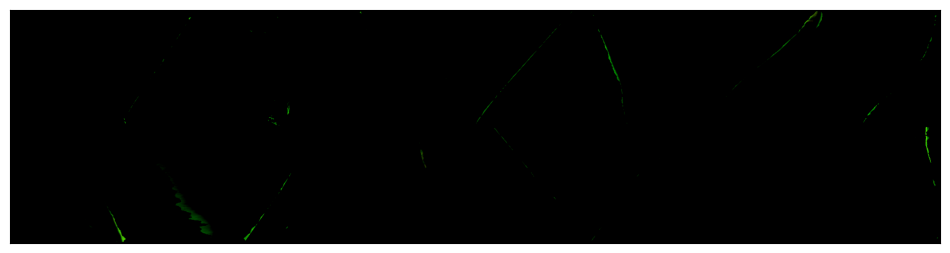

In [77]:
show_batch(train_dataloader)

In [ ]:
#@title
# def conv_block(in_channels, out_channels, pool=False):
#   layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
#           nn.BatchNorm2d(out_channels), 
#           nn.ReLU(inplace=True)]
#   if pool: layers.append(nn.MaxPool2d(2))
#   return nn.Sequential(*layers)

# class ResNet9(nn.Module):
#   def __init__(self, in_channels, num_classes):
#     super().__init__()
        
#     self.conv1 = conv_block(in_channels, 64)
#     self.conv2 = conv_block(64, 128, pool=True)
#     self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
#     self.conv3 = conv_block(128, 256, pool=True)
#     self.conv4 = conv_block(256, 512, pool=True)
#     self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
#     self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
#                     nn.Flatten(), 
#                     nn.Dropout(0.2),
#                     nn.Linear(512, num_classes))
        
#   def forward(self, xb):
#     out = self.conv1(xb)
#     out = self.conv2(out)
#     out = self.res1(out) + out
#     out = self.conv3(out)
#     out = self.conv4(out)
#     out = self.res2(out) + out
#     out = self.classifier(out)
#     return out

# model = ResNet9(3, 4)

In [20]:
d201 = torchvision.models.densenet201(pretrained=True)

# This will return how many features we'll have after flattening.
# num_features = d201.classifier.in_features
num_features = d201.classifier.in_features
# num_features

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [21]:
num_features

1920

In [22]:
# We did not get the last layer (prediction layer) 
# we'll add our prediction layer.
layers = list(d201.classifier.children())[:-1]
# layers = list(r101.fc.children())[:-1]
# layers.append(nn.Linear(num_features,4))

# d201.classifier = nn.Sequential(*layers)

# model = d201

In [23]:

'''
new_layers = nn.Sequential(
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(0.5),  # Dropout layer with dropout probability of 0.2
                nn.Linear(512, 4)
                #nn.Softmax(dim=1) # Create a softmax module that applies softmax along the second dimension (i.e., dimension 1)
                
             )

new_layers = nn.Sequential(
                nn.Flatten(),  # Flatten the output of the last convolutional layer
                
                nn.Linear(num_features, 1024),
                # nn.Linear(1920 * 7 * 7, 1024),  # Add a new linear layer with input size of 1920 * 7 * 7 and output size of 1024
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.5),  # Add a dropout layer to prevent overfitting

                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.5),  # Add a dropout layer to prevent overfitting

                nn.Linear(512, 4)  # Add the final linear layer with output size of num_classes
            )'''

new_layers = nn.Linear(num_features,4)            

layers.append(new_layers)

d201.classifier = nn.Sequential(*layers)

model = d201

In [ ]:
#@title
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# If train the entire model, set the requires_grad attribute of all parameters to True
for param in d201.parameters():
    param.requires_grad = True

# 4. Train the model ##

In [61]:
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# for drawing graph
acc_list, val_loss_list, precision_list, recall_list, f1_list = [],[],[],[],[]

train_acc_list, train_loss_list, train_precision_list, train_recall_list, train_f1_list = [],[],[],[],[]

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  train_predictions, train_targets = [], []
  for inputs, labels in train_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
        
    train_loss += loss.item()
    _, preds = torch.max(outputs, 1)
    train_predictions.extend(preds.cpu().numpy())
    train_targets.extend(labels.cpu().numpy())

  model.eval()
  with torch.no_grad():
    val_loss = 0
    predictions, targets = [], []
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #print(loss.item())
        val_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        targets.extend(labels.cpu().numpy())



        # Calculate metrics
    # print('t',targets[:15])
    # print('p',predictions[:15])

    
    # print(classification_report(targets, predictions))
    
    # print(len(targets))

    train_acc = accuracy_score(train_targets, train_predictions)
    train_loss /= len(train_dataloader)

    val_acc = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='weighted')
    recall = recall_score(targets, predictions, average='weighted')
    f1 = f1_score(targets, predictions, average='weighted')
    val_loss /= len(val_dataloader)

    # record data of train set
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    train_precision_list.append(precision_score(train_targets, train_predictions, average='weighted'))
    train_recall_list.append(recall_score(train_targets, train_predictions, average='weighted'))
    train_f1_list.append(f1_score(train_targets, train_predictions, average='weighted'))

    # record data of validation set
    acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}")
    #print(classification_report(targets, predictions))
  if epoch % 10 == 0:
    m_name = 'model_res101_add_layers.pth'
    # torch.save(model.state_dict(), DIR_MODEL + test_name)
    torch.save(model, DIR_MODEL + m_name)


Epoch 1/30
Train Loss: 0.6677, Train Accuracy: 0.7515
Validation Accuracy: 0.8179, Precision: 0.8244, Recall: 0.8179, F1 score: 0.8177
Epoch 2/30
Train Loss: 0.4204, Train Accuracy: 0.8480
Validation Accuracy: 0.7821, Precision: 0.8093, Recall: 0.7821, F1 score: 0.7892
Epoch 3/30
Train Loss: 0.2742, Train Accuracy: 0.9113
Validation Accuracy: 0.8448, Precision: 0.8513, Recall: 0.8448, F1 score: 0.8446
Epoch 4/30
Train Loss: 0.2301, Train Accuracy: 0.9247
Validation Accuracy: 0.8090, Precision: 0.8052, Recall: 0.8090, F1 score: 0.8000
Epoch 5/30
Train Loss: 0.1360, Train Accuracy: 0.9590
Validation Accuracy: 0.8119, Precision: 0.8127, Recall: 0.8119, F1 score: 0.8093
Epoch 6/30
Train Loss: 0.0959, Train Accuracy: 0.9713
Validation Accuracy: 0.8567, Precision: 0.8610, Recall: 0.8567, F1 score: 0.8577
Epoch 7/30
Train Loss: 0.0932, Train Accuracy: 0.9694
Validation Accuracy: 0.8567, Precision: 0.8582, Recall: 0.8567, F1 score: 0.8543
Epoch 8/30
Train Loss: 0.0762, Train Accuracy: 0.9765
V

In [63]:
# load trained model for testing
import torchvision.models as models

model_file = DIR_MODEL + 'model_res101_add_layers.pth'
testmodel = torch.load(model_file)
testmodel.eval()

def test_model(test_dataloader, model):
    with torch.no_grad():
      predictions, targets = [], []
      for inputs, labels in test_dataloader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = testmodel(inputs)
          _, preds = torch.max(outputs, 1)
          predictions.extend(preds.cpu().numpy())
          targets.extend(labels.cpu().numpy())

          # Calculate metrics
          # print('t',targets[:15])
          # print('p',predictions[:15])
          # print(classification_report(targets, predictions))
          # print(len(targets))
          #train_acc = accuracy_score(train_targets, train_predictions)
          #train_loss /= len(train_dataloader)

      acc = accuracy_score(targets, predictions)
      precision = precision_score(targets, predictions, average='weighted')
      recall = recall_score(targets, predictions, average='weighted')
      f1 = f1_score(targets, predictions, average='weighted')

      #print(f"Epoch {epoch+1}/{num_epochs}")
      #print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
      print(f"Test Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}")
      print(classification_report(targets, predictions))

test_model(test_dataloader, model)  

Test Accuracy: 0.8601, Precision: 0.8650, Recall: 0.8601, F1 score: 0.8564
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        51
           1       0.82      0.94      0.87       146
           2       0.85      0.62      0.72        55
           3       0.95      0.82      0.88        84

    accuracy                           0.86       336
   macro avg       0.88      0.83      0.85       336
weighted avg       0.87      0.86      0.86       336



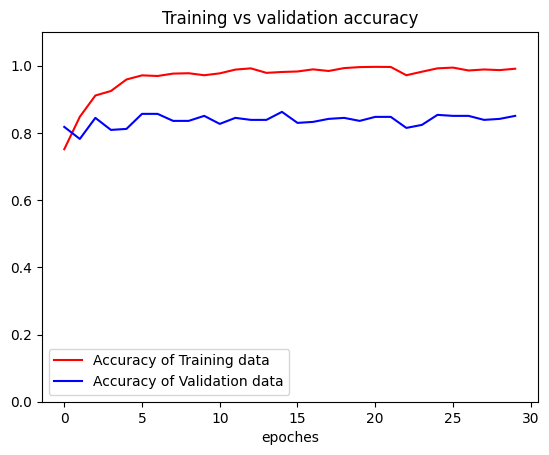

<Figure size 640x480 with 0 Axes>

In [66]:
from matplotlib.layout_engine import TightLayoutEngine
def plot(list1, list2, label1, label2, title, yl):
  epo = range(len(list1))
  plt.plot(epo, list1, 'r', label= label1)
  plt.plot(epo, list2, 'b', label= label2)
  plt.title(title)
  plt.legend(loc=0)
  plt.xlabel('epoches')
  plt.ylim(0,yl)
  plt.figure()
  plt.show()

plot(train_acc_list, acc_list, 'Accuracy of Training data', 'Accuracy of Validation data', 'Training vs validation accuracy',1.1 )

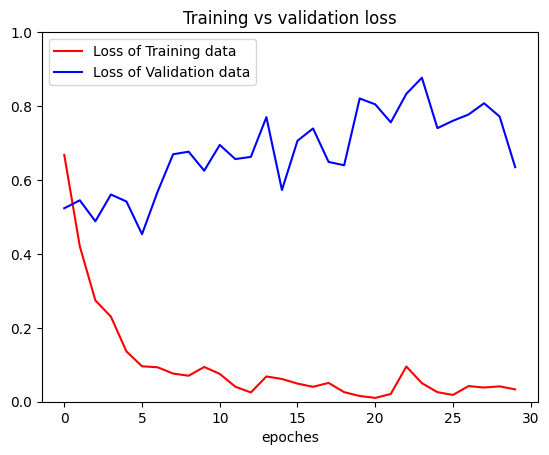

<Figure size 640x480 with 0 Axes>

In [68]:
#@title
plot(train_loss_list, val_loss_list, 'Loss of Training data', 'Loss of Validation data', 'Training vs validation loss',1 )

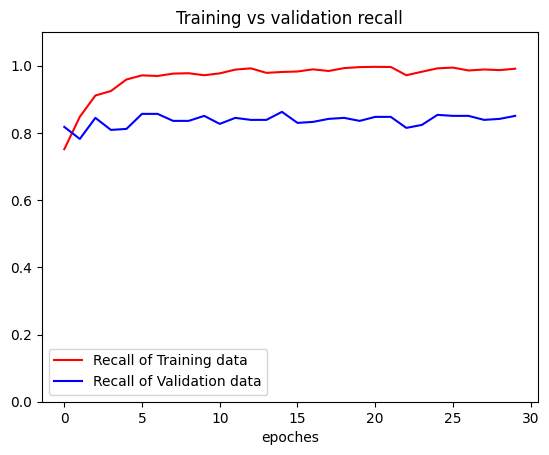

<Figure size 640x480 with 0 Axes>

In [72]:
plot(train_recall_list, recall_list, 'Recall of Training data', 'Recall of Validation data', 'Training vs validation recall',1.1 )

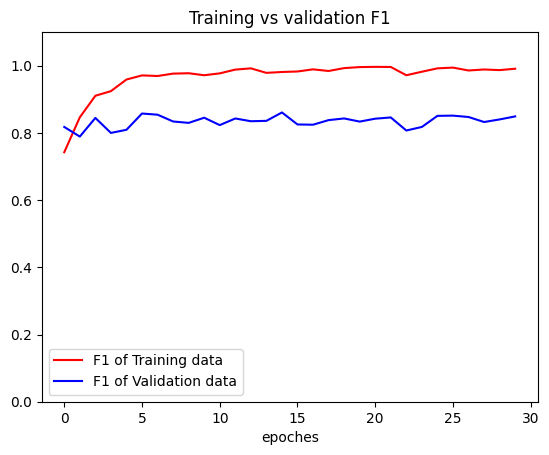

<Figure size 640x480 with 0 Axes>

In [73]:
plot(train_f1_list, f1_list, 'F1 of Training data', 'F1 of Validation data', 'Training vs validation F1',1.1 )

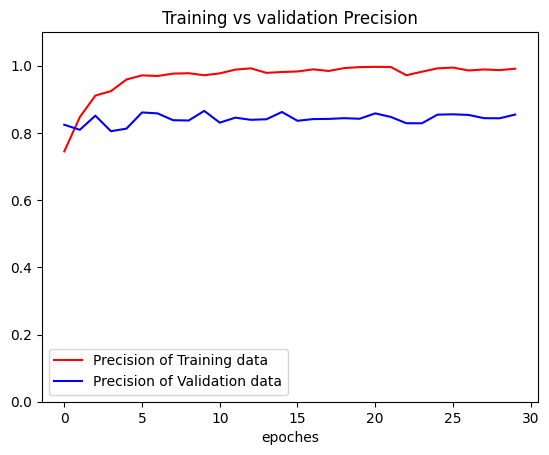

<Figure size 640x480 with 0 Axes>

In [74]:
plot(train_precision_list, precision_list, 'Precision of Training data', 'Precision of Validation data', 'Training vs validation Precision',1.1 )

In [42]:

# just for test

brown_spot = glob("../content/drive/MyDrive/train/BrownSpot/*")
healthy = glob("../content/drive/MyDrive/train/Health/*")
hispa = glob("../content/drive/MyDrive/train/Hispa/*")
leaf_blast = glob("../content/drive/MyDrive/train/LeafBlast/*")

print("Number of brown spot:",len(brown_spot))
print("Number of health:",len(healthy))
print("Number of hispa: ",len(hispa))
print("Number of leaf blast:",len(leaf_blast))

Number of brown spot: 523
Number of health: 1488
Number of hispa:  565
Number of leaf blast: 779


## Findings:
- We can observe the accuracy of using pre-processed images has increased 7.03% compared to the original images, which means the pre-processing of this dataset was effective. The accuracy 0.8601 has beaten other codes at Kaggle on this dataset.